In [1]:
using BenchmarkTools
using Random
using Plots

# Inizializza GR backend
gr()

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1273
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


Plots.GRBackend()

In [2]:
# Generate strengths of interactions between particle types
# Very simple but user could replace with anything they wanted
# Genera le intensità delle interazioni fra tipologie di particelle
# Modifiche: Cambio tipo da Float64 a Float32, inserito break perché matrice simmetrica
function gen_interaction(num_part_types)
    interaction_params = zeros(num_part_types, num_part_types)
    rng = MersenneTwister()
    for i=1:num_part_types
        for j = 1:num_part_types
            if (i==j) # Self-interaction is randomly repulsive
                interaction_params[i, j] = -rand(rng, Float32)
            elseif (i<j) # Others randomly attractive
                val = rand(rng, Float32)
                interaction_params[i,j] = val
                interaction_params[j,i] = val
            else
                continue # Inserito continue, arresta il ciclo, matrice simmetrica
            end
        end        
    end    
    return interaction_params
end

gen_interaction (generic function with 1 method)

In [3]:
# Test #
gen_interaction(5);
@time gen_interaction(5)

  0.000608 seconds (27 allocations: 20.656 KiB)


5×5 Array{Float64,2}:
 -0.11577    0.708502   0.625733    0.561323    0.110376
  0.708502  -0.103733   0.400042    0.389166    0.532171
  0.625733   0.400042  -0.571059    0.0995637   0.172449
  0.561323   0.389166   0.0995637  -0.463832    0.158301
  0.110376   0.532171   0.172449    0.158301   -0.775035

In [4]:
# Azzera l'array (o matrice) a, in-place
# a = Array n-dimensionale
function set_to_zero!(a)
    z = zero(eltype(a))
    @simd for i in eachindex(a)
        @inbounds a[i] = z
    end
    return nothing
end

#= Fonte: https://en.wikipedia.org/wiki/Periodic_boundary_conditions
Vedi "Pratical Implementation" =#
# Filtra la distanza fra due componenti delle particelle i e j se il sistema è periodico
# dist = Distanza tra i e j, può essere semplicemente j-i o ri-definita, Float
# box_size = dimensioni del box di simulazione (lato), Float
# restricted = true se una particella che esce dal box rientra dal lato opposto,
#              false se la particella è libera di muoversi ma interagisce con le repliche virtuali, Boolean
# Output: Float
function periodic_dcomp(dcomp, box_size, restricted)    
    r_size = 1. / box_size # costante, portare fuori o inline
    if restricted
        return dcomp - round(dcomp / box_size) * box_size
    else
        return dcomp - round(dcomp * r_size) * box_size
    end
end


periodic_dcomp (generic function with 1 method)

In [5]:
#= PRE: Ogni punto si trova all'interno del box (se box finito) garantito dalla funzione step_update! che gestisce 
le posizioni uscenti dal box ad ogni iterazione. =#
# Find force on each particle
# 1/r^2 interactions: Is very simple but user can replace with anything they want
function find_forces!(forces, pos, vel, acc, dim, part_num, part_types, interaction_params, mass_parts, box_size, periodic, restrict)
    # Aggiunta: Azzera forze, molto più veloce azzerare lo stesso array che crearne uno nuovo ad ogni step, parallelizzabile
    set_to_zero!(forces)
    # Per ogni particella i
    for i in 1:part_num
        # Calcola la massa di i
        mass1 = mass_parts[part_types[i]] # La massa non veniva usata nel codice originale!
        # Per ogni altra particella k diversa da i
        for k in 1:part_num # Contribution from every other particle
            if (k == i) continue end # Modifica: Solo per ridurre l'indentazione, non è necessario incapsulare tutto il codice che segue.
            #if (i != k) # No self-interaction
            # Modifica: int_strength portato fuori dal loop sottostante
            int_strength = interaction_params[part_types[i], part_types[k]] # Strength of interaction between particles
            # Concettualmente nel ciclo sottostante (per ciascuna dimensione) andrebbe chiamata la sola funzione
            # per il calcolo della forza su ciascuna dimensione dopo aver ottenuto le grandezze necessarie.
            # distanza fra particelle, massa e forza di interazione.
            mass2 = mass_parts[part_types[k]] # Massa della particella agente 
            
            
            #distance = @views Float32(euclidean(pos[i, :], pos[k, :])) # distanza euclidea
            
            # New version with fixes #
            min_distance = 1e-6 # Distanza minima consentita, evita distanze nulle: a questa distanza le forze si annullano
            distance = 0. # Distance value in dim space
            dcomps = Array{Float32}(undef, dim) # Distance components, on each axis
            force_strenght = 0
            for d in 1:dim
                dcomps[d] = pos[k, d] - pos[i, d]                
                if periodic 
                    dcomps[d] = periodic_dcomp(dcomps[d], box_size, restrict)
                end
                distance += dcomps[d]*dcomps[d]
            end
            distance = sqrt(distance)
            if distance > min_distance
                force_strength = int_strength * (1/(distance*distance)) # force formula
            end
            forces[i,:] .+= dcomps .* force_strength 
            
            
            #=
            #if periodic
             #   distance = periodic_dist(distance, sqrt(dim)*box_size, restrict)
            #end
            force_mod = int_strength * (1/(distance*distance)) # force formula
            # Per ciascuna dimensione (force decomposition)
            for d in 1:dim # For each dimension
                #= Il codice originale considera le forze agenti su ciascuna particella in modo strano:
                Se il sistema è periodico prevale la distanza massima tra quella normale (contenuta nel box)
                e quella periodica (seguendo il tagitto "pac-man style"), oltre al fatto che penso si debba invece
                considerare quella minima o entrambe simultaneamente, credo che sia meglio calcolare le forze 
                delle sole distanze contenute nel box a prescindere dal fatto che il sistema sia periodico o meno, 
                dato che ogni particella che supera il confine viene "teletrasportata" dal lato opposto. =#                    
                
                #= Find distance between particles    
                if (pos[i, j] > pos[k, j]) # Questo controllo può essere evitato senza calcolare il valore assoluto della distanza
                    int_strength = -1*int_strength # Reverses direction of force if positions flopped
                end
                    
                dist = 0.0
                if (periodic) # If periodic, check whether a periodic distance is shorter
                    dist = abs(pos[i,j] - pos[k,j])
                    if (pos[i,j] < pos[k,j])
                        new_dist = abs(box_size + pos[i,j] - pos[k,j])
                        if new_dist > dist
                            dist = new_dist
                            int_strength = -1*int_strength # Reverses direction of force
                        end
                    else
                        new_dist = abs(box_size + pos[k,j] - pos[i,j])
                        if new_dist > dist
                            dist = new_dist
                            int_strength = -1*int_strength # Reverses direction of force
                        end
                    end
                else # Otherwise, just regular distance
                    dist = abs(pos[i,j] - pos[k,j])
                end
                =#
                # Siccome la verlet prevede la scomposizione del calcolo per singola componente
                # La distanza va calcolata su ogni singola componente (unidimensionale)
                # Considera che nel caso si voglia usare la distanza geodedica ad esempio,
                # la curvatura comporta solo che per ciascuna componente il valore sarà ≤ alla distanza geodedica
                # per ora verrà considerata solo la semplice distanza a - b per singola componente
                #dist, pdist = monodistances(pos[i, j], pos[k, j], box_size, periodic)
                
                cdist = pos[k, d] - pos[i, d] 
                # Modifica: La distanza su ciascuna componente è utile solo se si conosce il modulo della forza
                # orientata lungo la distanza più breve
                
                if periodic 
                    cdist = periodic_dist(cdist, box_size, restrict)
                end
                
                # Nella formula finale si dovrebbe usare anche la massa di una particella
                #force[i,j] += int_strength / dist^2 # 1/r^2 interaction # Modifica: accumula le forze per una sola componente
                # Modifica, funzione ausiliaria per il calcolo della forza agente su una componente.                   
                #force[i, j] += monoforce(mass1, mass2, int_strength, min(dist, pdist)) # Forza agente sulla particella i per la componente j
                #if abs(cdist) >= 0.01 # Soglia per impedire forze tendenti ad infinito
                 #   force[i, d] += cdist*force_mod
                #end
                force[i, d] += cdist*force_mod
                
                end
            #end del vecchio if per escludere l'auto-interazione
            =#
        end
    end
    return nothing # Modifica C++ style
end

find_forces! (generic function with 1 method)

In [6]:
#= Fonte: https://en.wikipedia.org/wiki/Periodic_boundary_conditions
Vedi "Pratical Implementation" =#
# Quando il sistema è periodico, vincola una coordinata a rimanere nello stesso intervallo
# p = Coordinata di una particella su un certo asse, Float
# box_size = dimensioni del box di simulazione (lato), Float
# Output: Float
function restrict_pos(p, box_size)
    return p - floor(p / box_size) * box_size
end

restrict_pos (generic function with 1 method)

In [7]:
# Update position, velocity, and acceleration using Velocity Verlet Algorithm
# Can deal with infinite and finite systems
# For finite system, can be periodic or can reflect off walls
function step_update!(forces, pos, vel, acc, dim, part_num, part_types, mass_parts, dt, box_size, periodic, restrict)

    # Loop is completely parallelizale
    for i = 1:part_num # For every particle
        mass = mass_parts[part_types[i]]
        for j = 1:dim # For each dimension
            
            # Drag (forza di resistenza, simula attrito)
            drag = 0.6 # imposta a 0 per attrito nullo
            drag_force = 0.5 * drag * (vel[i, j] * abs(vel[i, j])) #drag * vel[i, j]  formula arbitraria
            drag_acc = drag_force / mass
            
            # Velocity Verlet algorithm
            pos[i, j] = pos[i, j] + vel[i, j]*dt + acc[i, j]*(dt*dt*0.5) # x(t+Δt) = x(t) + v(t)Δt + 1/2*a(t)(Δt)^2
            new_acc = forces[i, j] / mass
            vel[i, j] = vel[i, j] + (acc[i, j] + new_acc)*(dt*0.5) # v(t+Δt) = v(t) + 1/2*(a(t)+a(t+Δt))Δt
            acc[i, j] = new_acc - drag_acc # a = F/m             
            
            #=
            if (pos[i, j] == Inf || pos[i, j] == -Inf)
                println("$pos_before -> $(pos[i, j]), $vel_before -> $(vel[i, j]), $acc_before -> $(acc[i, j])")
                println("Acc -> $new_acc, Drag -> $drag_acc")
                break
            end=#
                     
            #=
            if (finite_box) # If finite box, check are still inside and correct if not
                if (periodic) # For periodic, just change position to be in box
                    if (pos[i,j] < 0) # If no longer in box
                        pos[i,j] = box_size + (pos[i,j] % box_size) # Warning! Il modulo è sconsigliato in questo caso
                    elseif (pos[i,j] > box_size) # If no longer in box
                        pos[i,j] = pos[i,j] % box_size  # Warning! Il modulo è sconsigliato in questo caso                      
                    end
                else # If not periodic, more complicated - reflects off walls
                    if (pos[i,j] < 0) # If no longer in box
                        pos[i,j] = -1*(pos[i,j])    # Perché? OK, Per riportare la particella nel box
                    elseif (pos[i,j] > box_size) # If no longer in box
                        pos[i,j] = box_size - pos[i,j] # Perché? Questo riporta la particella nella pos sbagliata...
                    end
                    vel[i,j] = -1*(vel[i,j])
                    acc[i,j] = -1*(acc[i,j])
                end
            end
            =#                 
            
            bounce = 0.8 # 1 per rimbalzi perfettamente elastici
            if periodic && restrict # Pac-Man like
                pos[i, j] = restrict_pos(pos[i, j], box_size)                     
            elseif !periodic && restrict # Reflect on walls
                if pos[i, j] < 0 || pos[i, j] > box_size
                    pos[i, j] = box_size - restrict_pos(pos[i, j], box_size)                    
                    vel[i, j] = -vel[i, j] * bounce
                    acc[i, j] = -acc[i, j] * bounce
                end                
            end
            
           
        end
    end    
    # return pos, vel, acc # No need to return b/c is passed by reference
    return nothing # Modifica, C++ style
end

step_update! (generic function with 1 method)

In [8]:
#= Saving function
Salva i valori dell'istante t nella matrice trace =#
# now = Matrice con i valori dell'istante t
# trace = Matrice con i valori per ogni istante
# t = istante corrente
function save!(now, trace, t)
    for r in 1:size(now, 1)
        for c in 1:size(now, 2)
            trace[t, r, c] = now[r, c]
        end
    end
end

save! (generic function with 1 method)

In [22]:
#= The main program function, take in some parameters, returns a 3D matrix of positions for each time interval.

-> Input:
1. number_of_steps = Numero di iterazioni della simulazione, intero positivo [1, +∞)
2. dim = Numero di dimensioni dello spazio (2D o 3D), intero positivo, tipicamente [2,3]
3. box_size = Lunghezza di un lato del box di simulazione (quadrato o cubo), float positivo [1.0, +∞)
4. finite_box = Vero se il campo è finito <APPROFONDIRE, booleano [true, false] # ELIMINATO
5. periodic = Vero se la simulazione è periodica (pac-man), booleano [true, false]
6. part_num = Numero di particelle da simulare, intero positivo [1, +∞) 
7. dt = Grandezza del passo temporale, float positivo preferibilmente piccolo (0, +∞)
8. num_part_types = Numero di tipologie di particelle, intero positivo [1, +∞)
9. save_interval = Ogni quanti steps viene salvata la posizione, intero positivo [1, number_of_steps]
# Nuove variabili (?)
10. load_from_disk = Vero se si vuole caricare da disco i dati di una simulazione precedente (sovrascrive alcuni parametri)
11. save_on_disk = Vero se si vuole salvare su disco lo stato finale della simulazione

<- Output:
1. saved_positions = Sequenza temporale delle posizioni di ciascuna particella, matrice 3D, num_pos x part_num x dim
(num_pos = Numero di posizioni da salvare, funzione di number_of_steps e save_interval )
============================#
# Modifica: eliminato finite_box, ogni sistema è finito basta variare la dimensione del box a quella massima
function dynamics_simulation(number_of_steps, dim, box_size, periodic, restrict, part_num, dt, num_part_types, save_interval)
    # Inizializza strutture dati (Random default) 
    # Costanti dipendenti dai parametri
    interaction_params = gen_interaction(num_part_types) #fill(0.7, num_part_types, num_part_types) parametri di interazione, matrice quadrata, num_part_types^2
    mass_parts = rand(Float32, num_part_types) .* 0.9 .+ 0.1 #ones(Float32, num_part_types) Massa per ogni tipo di particella, array di Float32, WARNING! NO masse nulle
    part_types = rand(1:num_part_types, part_num) # Tipologia di particella per ogni particella, array di Int
      
    # Variabili aggiornate ad ogni iterazione
    pos = box_size.*rand(Float32, part_num, dim) # Initialized to be randomly placed within a box (Usare funzione?)
    vel = zeros(Float32, part_num, dim) # Initialized to zero
    acc = zeros(Float32, part_num, dim) # Initialized to zero
    forces = Array{Float32}(undef, part_num, dim) # Viene azzerato all'inizio di ogni ciclo
    
    # Variabili per il salvataggio
    num_pos = number_of_steps ÷ save_interval #floor(Int, number_of_steps / save_interval) + 1 # Numero di posizioni da salvare
    saved_positions = Array{Float32}(undef, num_pos, part_num, dim) #zeros(num_pos, part_num, dim)
    saved_velocities = Array{Float32}(undef, num_pos, part_num, dim) #zeros(num_pos, part_num, dim) # Save velocities with specified frequency
    saved_accelerations = Array{Float32}(undef, num_pos, part_num, dim) #zeros(num_pos, part_num, dim) # Save accelerations with specified frequency
    saved_forces = Array{Float32}(undef, num_pos, part_num, dim) #zeros(num_pos, part_num, dim) # Save forces with specified frequency
    
    
    save_index = 1 # contatore salvataggi
    # Calcolo delle forze agenti su ciascuna particella
    # Modifica: calcolo prima le forze e poi aggiorno con verlet direttamente nel loop
    # Loop per ciascuno step
    for t in 1:number_of_steps
        # Calcola forze agenti su ciascuna particella, (todo: parametri superflui part_num, part_types?)
        find_forces!(forces, pos, vel, acc, dim, part_num, part_types, interaction_params, mass_parts, box_size, periodic, restrict)
        # aggiornamento step
        step_update!(forces, pos, vel, acc, dim, part_num, part_types, mass_parts, dt, box_size, periodic, restrict)        
        # Salvataggi
        # Salva posizioni (TODO: funzione per il salvataggio save!(m2, m3) m2 matrice 2D, m3 matrice 3D
        if (t-1) % save_interval == 0
            save!(pos, saved_positions, save_index)
            save_index += 1
            # Se salvi su disco salva anche vel, acc e force
        end
        
    end
    # Restituisci le posizioni per intervallo di tempo
    return saved_positions, vel
end

dynamics_simulation (generic function with 1 method)

In [23]:
dynamics_simulation(20, 3, 10.0, false, true, 20, 0.01, 3, 1);
#@time dynamics_simulation(1000, 3, 10.0, false, true, 20, 0.01, 3, 2);

In [26]:
# 3D Simulation
duration = 30
spos, vel = dynamics_simulation(30*duration, 3, 10.0, false, true, 50, 1/30, 3, 1);

┌ Info: Saved animation to 
│   fn = /home/erratic/Scrivania/Git/molecular-dynamics-cuda/main/serial3d.gif
└ @ Plots /home/erratic/.julia/packages/Plots/12uaJ/src/animation.jl:98


Plots.AnimatedGif("/home/erratic/Scrivania/Git/molecular-dynamics-cuda/main/serial3d.gif")
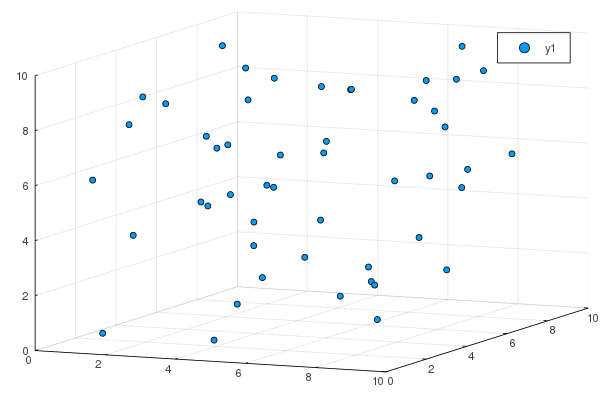

In [27]:
anim = @animate for i in 1:size(spos, 1)
    plot(spos[i,:,1], spos[i,:,2], spos[i,:,3], lims=(0, 10), linetype=:scatter)
end every 1

gif(anim, "./serial3d.gif", fps=30)

In [13]:
#@benchmark dynamics_simulation(100, 3, 10.0, true, true, 20, 0.01, 3, 2)

In [28]:
#2D Real time @30fps
spos, vel = dynamics_simulation(30*duration, 2, 10, true, true, 30, 1/30, 3, 1);

┌ Info: Saved animation to 
│   fn = /home/erratic/Scrivania/Git/molecular-dynamics-cuda/main/serial2d.gif
└ @ Plots /home/erratic/.julia/packages/Plots/12uaJ/src/animation.jl:98


Plots.AnimatedGif("/home/erratic/Scrivania/Git/molecular-dynamics-cuda/main/serial2d.gif")
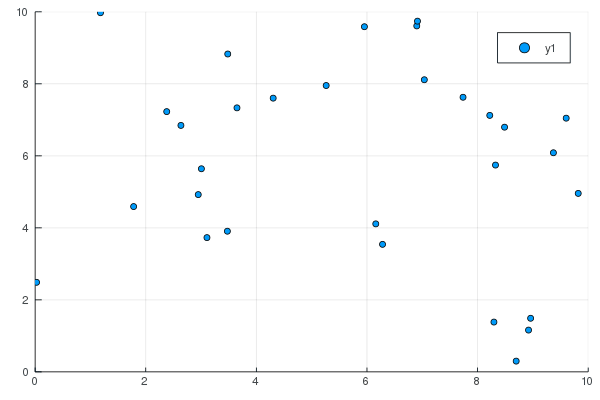

In [29]:
anim2d = @animate for i in 1:size(spos, 1)
    plot(spos[i,:,1], spos[i,:,2], lims=(0, 10), linetype=:scatter)
end every 1

gif(anim2d, "./serial2d.gif", fps=30)